## Hypertuning a model for the best hyperparameters

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import MeanSquaredError, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras import regularizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

In [2]:
def make_dataframe(sdir):
    # sdir is the directory when the class subdirectories are stored
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath))
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    # return a dataframe with columns filepaths, labels
    return df

def make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg'):
    # augdir is the full path where augmented images will be stored
    # n is the number of augmented images that will be created for each class that has less than n image samples
    # img_size is a tupple(height,width) that specifies the size of the augmented images
    # color_mode is 'rgb by default'
    # save_prefix is the prefix augmented images are identified with by default it is 'aug-'
    # save_format is the format augmented images will be save in, by default it is 'jpg'
    # see documentation of ImageDataGenerator at https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for details
    df=df.copy()
    if os.path.isdir(augdir):# start with an empty directory
        shutil.rmtree(augdir)
    os.mkdir(augdir)  # if directory does not exist create it
    for label in df['labels'].unique():
        classpath=os.path.join(augdir,label)
        os.mkdir(classpath) # make class directories within aug directory
    # create and store the augmented images
    total=0
    # in ImageDateGenerator select the types of augmentation you desire below are some examples
    gen=image.ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=.1,
                                 height_shift_range=.1)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        classdir=os.path.join(augdir, label)
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=classdir, save_prefix=save_prefix, color_mode=color_mode,
                                            save_format=save_format, seed=42)
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

## Differentiating between viral and bacterial pneunomia
The x-ray images also contain data according to the etiology of pneunomia (viral or bacterial). We can again apply the same procedure to determine the best model for differentiating between the two causes, or we can use the `VGG16()` model. Due to the complexity of the model, I ran the data through my desktop with a Nvidia GeForce RTX 3060.
<br>
<br>However, we can balance the `VIRUS` and `BACTERIA` classes using the same process as before.

In [3]:
train_directory = 'Data/chest_xray/train/'
df = make_dataframe(train_directory)

df_pneumonia = df[df['filepaths'].str.contains('PNEUMONIA')]
df_pneumonia = df_pneumonia.drop(['labels'], axis=1) # drop the labels column so we can create a new one
df_pneumonia.head()

PNEUMONIA                : 100%|███████████████████████████████████████████████████████| 3883/3883 [00:00<00:00, 388198.56files/s]


,filepaths
1349,Data/chest_xray/train/PNEUMONIA\BACTERIA-10080...
1350,Data/chest_xray/train/PNEUMONIA\BACTERIA-10255...
1351,Data/chest_xray/train/PNEUMONIA\BACTERIA-10271...
1352,Data/chest_xray/train/PNEUMONIA\BACTERIA-10334...
1353,Data/chest_xray/train/PNEUMONIA\BACTERIA-10379...


In [4]:
df_pneumonia['labels'] = df['filepaths'].str.extract('(BACTERIA|VIRUS)')[0]
df_pneumonia['labels'].value_counts()

labels
BACTERIA    2538
VIRUS       1345
Name: count, dtype: int64

In [5]:
augment_viral_dir='Data\Augmented_Virus'

make_and_store_images(df_pneumonia, augment_viral_dir, n=2500, img_size=(256,256), color_mode='rgb', save_prefix='aug-',save_format='jpg')

Found 1345 validated image filenames.    for class             VIRUS              creating 1155  augmented images 
Total Augmented images created=  1155


In [6]:
aug_virus_df = make_dataframe(augment_viral_dir)

BACTERIA                 : 0files [00:00, ?files/s]
VIRUS                    : 100%|███████████████████████████████████████████████████████| 1155/1155 [00:00<00:00, 384905.54files/s]


In [7]:
under_df_pneumonia = df_pneumonia[df_pneumonia['filepaths'].str.contains('BACTERIA')].sample(n=2500, random_state=42, ignore_index=False)

balanced_df_pneumonia = pd.concat([under_df_pneumonia, df_pneumonia[df_pneumonia['filepaths'].str.contains('VIRUS')], aug_virus_df], ignore_index=True)
balanced_df_pneumonia = shuffle(balanced_df_pneumonia, random_state=42)

balanced_df_pneumonia['labels'].value_counts()

labels
BACTERIA    2500
VIRUS       2500
Name: count, dtype: int64

In [8]:
target_size = (224, 224)
batch_size = 32

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         validation_split=0.2
                                        )

In [9]:
metrics = [
    'acc',
    MeanSquaredError(name='Brier score'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR')
]

In [10]:
pneumonia_train_generator = train_datagen.flow_from_dataframe(
    balanced_df_pneumonia,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

pneumonia_validation_generator = train_datagen.flow_from_dataframe(
    balanced_df_pneumonia,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


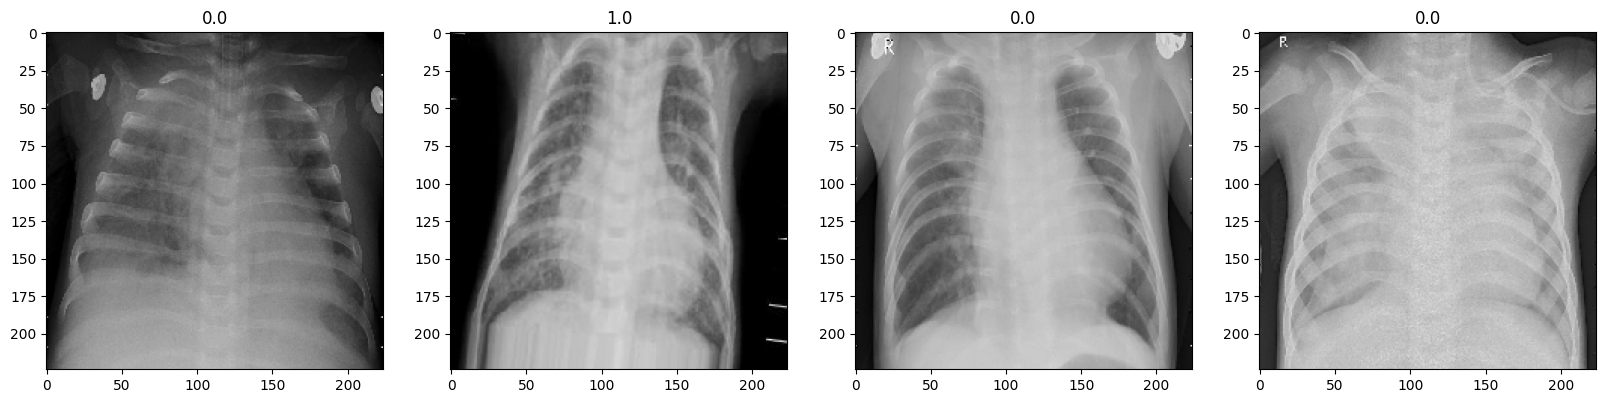

In [11]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(pneumonia_train_generator[0][0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(pneumonia_train_generator[0][1][idx])

In [12]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16()
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
metrics = [
    'acc',
    MeanSquaredError(name='Brier score'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR')
]

In [14]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)
    for layer in model.layers:
        layer.trainable = False

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

In [16]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=False)

model_history=model.fit(
    pneumonia_train_generator,
    steps_per_epoch=int(np.ceil(4000/batch_size)),
    epochs=60,
    validation_data=pneumonia_validation_generator,
    validation_steps=int(np.ceil(1000/batch_size)),
    callbacks=[early_stop]
)

Epoch 1/60
125/125 [==============================] - 41s 238ms/step - loss: 0.6931 - acc: 0.5288 - Brier score: 0.2500 - tp: 1788.0000 - fp: 1673.0000 - tn: 327.0000 - fn: 212.0000 - precision: 0.5166 - recall: 0.8940 - auc: 0.4990 - prc: 0.4992 - val_loss: 0.6927 - val_acc: 0.5790 - val_Brier score: 0.2498 - val_tp: 105.0000 - val_fp: 26.0000 - val_tn: 474.0000 - val_fn: 395.0000 - val_precision: 0.8015 - val_recall: 0.2100 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/60
125/125 [==============================] - 20s 163ms/step - loss: 0.6926 - acc: 0.5750 - Brier score: 0.2497 - tp: 1310.0000 - fp: 1010.0000 - tn: 990.0000 - fn: 690.0000 - precision: 0.5647 - recall: 0.6550 - auc: 0.5257 - prc: 0.5378 - val_loss: 0.6923 - val_acc: 0.6430 - val_Brier score: 0.2496 - val_tp: 279.0000 - val_fp: 136.0000 - val_tn: 364.0000 - val_fn: 221.0000 - val_precision: 0.6723 - val_recall: 0.5580 - val_auc: 0.5288 - val_prc: 0.5235
Epoch 3/60
125/125 [==============================] - 20s 163ms/ste

Epoch 19/60
125/125 [==============================] - 22s 175ms/step - loss: 0.6862 - acc: 0.6332 - Brier score: 0.2465 - tp: 1152.0000 - fp: 619.0000 - tn: 1381.0000 - fn: 848.0000 - precision: 0.6505 - recall: 0.5760 - auc: 0.6855 - prc: 0.6616 - val_loss: 0.6854 - val_acc: 0.6410 - val_Brier score: 0.2461 - val_tp: 334.0000 - val_fp: 193.0000 - val_tn: 307.0000 - val_fn: 166.0000 - val_precision: 0.6338 - val_recall: 0.6680 - val_auc: 0.6967 - val_prc: 0.6751
Epoch 20/60
125/125 [==============================] - 21s 168ms/step - loss: 0.6859 - acc: 0.6298 - Brier score: 0.2464 - tp: 1499.0000 - fp: 980.0000 - tn: 1020.0000 - fn: 501.0000 - precision: 0.6047 - recall: 0.7495 - auc: 0.6842 - prc: 0.6612 - val_loss: 0.6850 - val_acc: 0.6410 - val_Brier score: 0.2459 - val_tp: 328.0000 - val_fp: 187.0000 - val_tn: 313.0000 - val_fn: 172.0000 - val_precision: 0.6369 - val_recall: 0.6560 - val_auc: 0.6951 - val_prc: 0.6714
Epoch 21/60
125/125 [==============================] - 21s 166ms

125/125 [==============================] - 21s 166ms/step - loss: 0.6804 - acc: 0.6430 - Brier score: 0.2436 - tp: 1303.0000 - fp: 731.0000 - tn: 1269.0000 - fn: 697.0000 - precision: 0.6406 - recall: 0.6515 - auc: 0.6894 - prc: 0.6670 - val_loss: 0.6791 - val_acc: 0.6410 - val_Brier score: 0.2430 - val_tp: 328.0000 - val_fp: 187.0000 - val_tn: 313.0000 - val_fn: 172.0000 - val_precision: 0.6369 - val_recall: 0.6560 - val_auc: 0.7001 - val_prc: 0.6781
Epoch 37/60
125/125 [==============================] - 21s 168ms/step - loss: 0.6801 - acc: 0.6398 - Brier score: 0.2435 - tp: 1237.0000 - fp: 678.0000 - tn: 1322.0000 - fn: 763.0000 - precision: 0.6460 - recall: 0.6185 - auc: 0.6901 - prc: 0.6703 - val_loss: 0.6788 - val_acc: 0.6420 - val_Brier score: 0.2428 - val_tp: 330.0000 - val_fp: 188.0000 - val_tn: 312.0000 - val_fn: 170.0000 - val_precision: 0.6371 - val_recall: 0.6600 - val_auc: 0.6986 - val_prc: 0.6765
Epoch 38/60
125/125 [==============================] - 20s 163ms/step - loss

Epoch 54/60
125/125 [==============================] - 20s 162ms/step - loss: 0.6750 - acc: 0.6375 - Brier score: 0.2409 - tp: 1348.0000 - fp: 798.0000 - tn: 1202.0000 - fn: 652.0000 - precision: 0.6281 - recall: 0.6740 - auc: 0.6934 - prc: 0.6733 - val_loss: 0.6733 - val_acc: 0.6380 - val_Brier score: 0.2401 - val_tp: 318.0000 - val_fp: 180.0000 - val_tn: 320.0000 - val_fn: 182.0000 - val_precision: 0.6386 - val_recall: 0.6360 - val_auc: 0.7019 - val_prc: 0.6816
Epoch 55/60
125/125 [==============================] - 20s 163ms/step - loss: 0.6747 - acc: 0.6380 - Brier score: 0.2408 - tp: 1349.0000 - fp: 797.0000 - tn: 1203.0000 - fn: 651.0000 - precision: 0.6286 - recall: 0.6745 - auc: 0.6925 - prc: 0.6714 - val_loss: 0.6730 - val_acc: 0.6440 - val_Brier score: 0.2399 - val_tp: 329.0000 - val_fp: 185.0000 - val_tn: 315.0000 - val_fn: 171.0000 - val_precision: 0.6401 - val_recall: 0.6580 - val_auc: 0.7027 - val_prc: 0.6826
Epoch 56/60
125/125 [==============================] - 20s 162ms

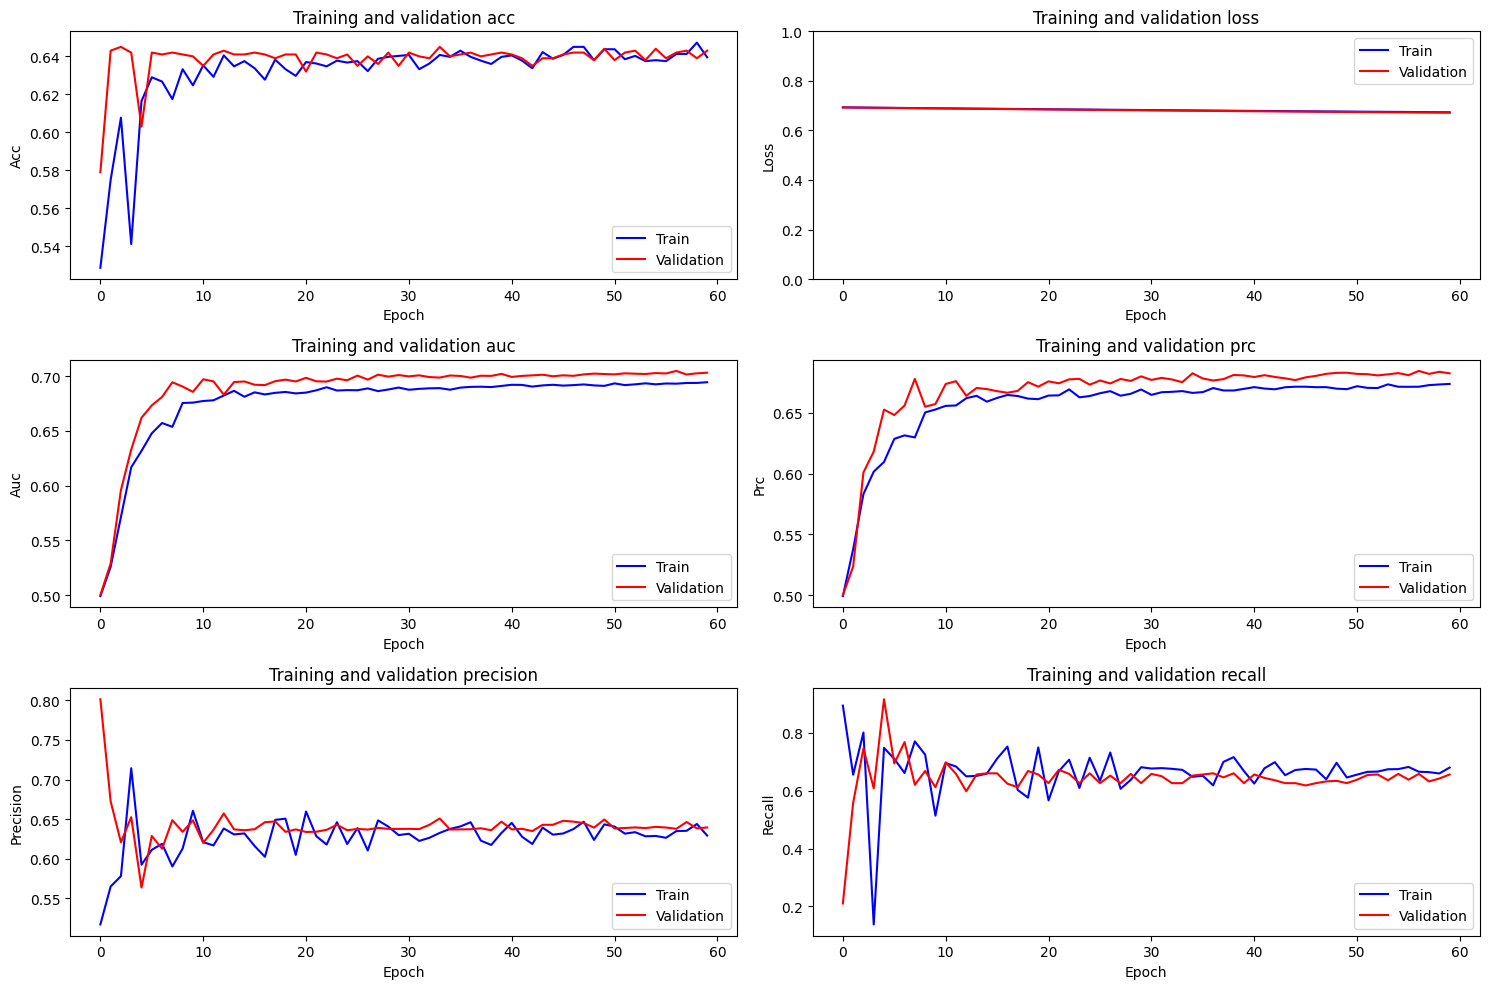

In [17]:
fig, axs = plt.subplots(3,2, figsize=(15, 10), dpi=100)
axs = axs.ravel()

metric_list = ['acc','loss', 'auc', 'prc', 'precision', 'recall']

for n, metric in enumerate(metric_list):
    name = metric.capitalize()
        

    axs[n].plot(model_history.epoch, model_history.history[metric], color='b', label='Train')
    axs[n].plot(model_history.epoch, model_history.history['val_'+metric], color='r', label='Validation')

    axs[n].set_xlabel('Epoch')
    axs[n].set_ylabel(name)
    axs[n].set_title('Training and validation {}'.format(metric))

    if metric == 'loss':
        axs[n].legend(loc='upper right')
        axs[n].set_ylim(0, 1.0)

    else:
        axs[n].legend(loc='lower right')

plt.tight_layout()

In [18]:
test_directory = 'Data/chest_xray/test/'

df_test = make_dataframe(test_directory)

PNEUMONIA                : 100%|█████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 389749.48files/s]


In [19]:
df_test = df_test[df_test['filepaths'].str.contains('PNEUMONIA')]
df_test.head()

,filepaths,labels
234,Data/chest_xray/test/PNEUMONIA\BACTERIA-113526...,PNEUMONIA
235,Data/chest_xray/test/PNEUMONIA\BACTERIA-113526...,PNEUMONIA
236,Data/chest_xray/test/PNEUMONIA\BACTERIA-113526...,PNEUMONIA
237,Data/chest_xray/test/PNEUMONIA\BACTERIA-113526...,PNEUMONIA
238,Data/chest_xray/test/PNEUMONIA\BACTERIA-122048...,PNEUMONIA


In [20]:
df_test = df_test.drop(labels='labels', axis=1)
df_test['labels'] = df_test['filepaths'].str.extract('(BACTERIA|VIRUS)')[0]
df_test['labels'].value_counts()

labels
BACTERIA    242
VIRUS       148
Name: count, dtype: int64

In [21]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 390 validated image filenames belonging to 2 classes.


In [22]:
test_labels = []

for x in range(0, len(test_generator)):
    test_labels.extend(np.array(test_generator[x][1]))
    
print('0 occurences: ', test_labels.count(0))
print('1 occurences: ', test_labels.count(1))

0 occurences:  242
1 occurences:  148


13/13 [==============================] - 4s 299ms/step


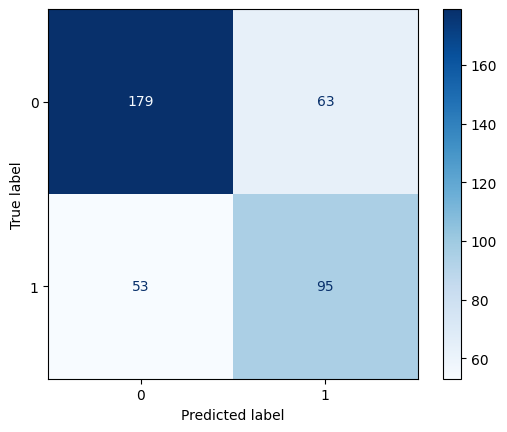

In [23]:
y_hat = model.predict(test_generator, batch_size=batch_size, steps=len(test_generator))
y_hat = np.rint(y_hat.reshape(390,))

cm = confusion_matrix(test_labels, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(y_test, y_hat):
    print("Precision Score: {}".format(precision_score(y_test, y_hat)))
    print("Recall Score: {}".format(recall_score(y_test, y_hat)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat)))
    print("F1 Score: {}".format(f1_score(y_test, y_hat)))

In [25]:
print_metrics(test_labels, y_hat)

Precision Score: 0.6012658227848101
Recall Score: 0.6418918918918919
Accuracy Score: 0.7025641025641025
F1 Score: 0.6209150326797386
